In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

# 配置搜索路径
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import backtrader as bt
import pandas as pd
import numpy as np
import pprint
import sqlite3
import math
from tqdm import tqdm
from datetime import datetime
from Offline.strategies.ml_based_strategy_latest_回归策略 import CustomMLStrategy
# from Offline.strategies.ml_based_strategy_latest_回归策略_v2 import CustomMLStrategy
from backtest_utils import CustomCommissionSchema, CustomAnalyzer

from Share.database_auto.db_data_downloader.downloader_base import DownloaderBase
import Share.database_auto.database_config as db_config

In [2]:
BACKTEST_INDEX_SYMBOLS = "000016"  # 【选股】策略的对比基准=指数index，【择时】策略的对比基准=单股自身
# ---- 回归任务
model_pred_df = pd.read_pickle(f'./backtest_data/test/{BACKTEST_INDEX_SYMBOLS}_2019-01-01_三分类任务_v6.pkl')
# model_pred_df = pd.read_pickle(f'./backtest_data/test/{BACKTEST_INDEX_SYMBOLS}_2019-01-01_分类任务_v6.pkl')
# model_pred_df['label_pred'] = 1 - model_pred_df['label_pred']
# model_pred_df = pd.read_pickle(f'./backtest_data/test/000016_2019-01-01_回归任务_v7_online.pkl')
model_pred_df = model_pred_df.rename(columns={'label_pred_2':'label_pred'})

In [3]:
model_pred_df.head()

,stock_code,stock_name,datetime,label_pred_0,label_pred_1,label_pred
130163,sh.601633,长城汽车,2019-01-02,0.236453,0.392881,0.370666
158325,sh.603259,药明康德,2019-01-02,0.286431,0.330983,0.382585
144809,sh.601888,中国中免,2019-01-02,0.241540,0.355941,0.402519
162340,sh.603501,韦尔股份,2019-01-02,0.252594,0.366358,0.381048
100853,sh.601166,兴业银行,2019-01-02,0.192256,0.368884,0.438860


In [4]:
# model_pred_df = model_pred_df[model_pred_df['stock_code'] == 'sh.600028']
# model_pred_df = model_pred_df[model_pred_df['datetime'] >= '2024-01-01']

In [5]:
# 构建数据里表
BACKTEST_STOCK_SYMBOLS = model_pred_df['stock_code'].unique().tolist()
print(BACKTEST_STOCK_SYMBOLS)
BACKTEST_START_DATE = model_pred_df['datetime'].min()  # 回测开始日期
BACKTEST_END_DATE = model_pred_df['datetime'].max()  # 回测结束日期
print(f'StartDate: {BACKTEST_START_DATE}, EndDate: {BACKTEST_END_DATE}')

['sh.601633', 'sh.603259', 'sh.601888', 'sh.603501', 'sh.601166', 'sh.600406', 'sh.603799', 'sh.601088', 'sh.600031', 'sh.601398', 'sh.600893', 'sh.600111', 'sh.601601', 'sh.600690', 'sh.601857', 'sh.600150', 'sh.601288', 'sh.601988', 'sh.600104', 'sh.601012', 'sh.600028', 'sh.601899', 'sh.601919', 'sh.601318', 'sh.600050', 'sh.601225', 'sh.601669', 'sh.600519', 'sh.600438', 'sh.600809', 'sh.600309', 'sh.603288', 'sh.600887', 'sh.600048', 'sh.601628', 'sh.603986', 'sh.601668', 'sh.600436', 'sh.600089', 'sh.600036', 'sh.600276', 'sh.601390', 'sh.600900', 'sh.600030', 'sh.688111', 'sh.688599', 'sh.688981', 'sh.600905', 'sh.601728', 'sh.688041']
StartDate: 2019-01-02, EndDate: 2024-05-13


In [6]:
# 初始化db_downloader
db_conn = sqlite3.connect("../../Share/database_auto/hh_quant_auto.db")
db_downloader = DownloaderBase(db_conn=db_conn, db_config=db_config)
dd = db_downloader._download_all_stock_info()
dd[dd['code'] == f'sh.{BACKTEST_INDEX_SYMBOLS}']

,code,code_name,in_date,out_date,type,status,industry
985,sh.000016,上证50指数,2004-01-02,,指数,上市,None


In [7]:
# 初始化backtrader相关参数
cerebro = bt.Cerebro()
BACKTEST_INITIAL_CASH = 200000  # 初始化资金

print("开始设置回测基础参数...")
cerebro.broker.setcash(BACKTEST_INITIAL_CASH)  # 配置初始资金量
cerebro.broker.addcommissioninfo(CustomCommissionSchema())  # 配置自定义的佣金类型
cerebro.broker.set_slippage_perc(perc=0.0001) # 配置自定义的滑点类型

# 获取回测区间的所有交易日期来构建统一的Index索引
BACKTEST_DATETIME_INDEX = pd.to_datetime(sorted(model_pred_df['datetime'].unique()))

print("开始添加回测股票数据...")
for stock_symbol in tqdm(BACKTEST_STOCK_SYMBOLS):
    stock_data = db_downloader._download_history_base_info(stock_symbol, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
    if not stock_data.empty:
        stock_data = stock_data[["datetime", "open", "high", "low", "close", "volume"]]
        stock_data["datetime"] = pd.to_datetime(stock_data["datetime"])
        stock_data = stock_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='ffill')
        stock_data_feeds = bt.feeds.PandasData(dataname=stock_data)  # 构建回测数据Feeds流
        cerebro.adddata(stock_data_feeds, name=stock_symbol)  # 添加回测数据

print("开始添加基准数据...")
BENCHMARK_SYMBOLS = 'sh.' + BACKTEST_INDEX_SYMBOLS
benchmark_data = db_downloader._download_history_base_info(BENCHMARK_SYMBOLS, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
benchmark_data = benchmark_data[["datetime", "open", "high", "low", "close", "volume"]]
benchmark_data["datetime"] = pd.to_datetime(benchmark_data["datetime"])
benchmark_data = benchmark_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='ffill')
benchmark_name = f"benchmark_{BENCHMARK_SYMBOLS}"
benchmark_data_feeds = bt.feeds.PandasData(dataname=benchmark_data)  # 构建基准数据Feeds流
cerebro.adddata(benchmark_data_feeds, name=benchmark_name)  # 添加基准数据

print("开始添加分析器...")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")  # 添加最大回撤的分析器，后续customAnalyzer中需要用到
cerebro.addanalyzer(CustomAnalyzer, _name="custom_analyzer")  # 添加自定义的分析器

# print("开始添加观察器...")
# cerebro.addobserver(bt.observers.Benchmark, data=benchmark_data_feeds, timeframe=bt.TimeFrame.NoTimeFrame)  # 添加基准对比观察器

开始设置回测基础参数...
开始添加回测股票数据...


100%|██████████| 50/50 [00:00<00:00, 199.26it/s]

开始添加基准数据...
开始添加分析器...


In [8]:
print("开始添加策略...")
strategy_params = {
    "benchmark": benchmark_name,
    "model_pred_dataframe": model_pred_df,
}

lower_bound, upper_boumd = np.nanquantile(model_pred_df['label_pred'], [0.2, 0.8])
print(f"lower_bound: {lower_bound}, upper_bound: {upper_boumd}")

strategy_params.update(
    {
        "max_position_proportion": 0.15,  # 最大持仓资金占比
        "min_holding_period": 0,  # 最小持仓周期
        "max_holding_period": 20,  # 最大持仓周期
        "top_n": 5,  # 每日选择股票的TopN
        "min_buy_cash": 2000,  # 最小购买资金限制
        "atr_period": 14,  # ATR计算周期
         "init_trailing_stop_loss_factor": 1.5,  # 首次买入跟踪止损位 = 1.5ATR
        "update_trailing_stop_loss_factor": 1,  # 更新跟踪止损位 = 1ATR
        "atr_risk": 0.05,  # ATR风险系数
        "buy_pred_upper_bound": upper_boumd,
        "sell_pred_lower_bound": lower_bound
    }
)

cerebro.addstrategy(CustomMLStrategy, **strategy_params)

开始添加策略...
lower_bound: 0.3793826699256897, upper_bound: 0.44102652072906495


0

In [9]:
print("开始运行回测...")
# 运行回测
results = cerebro.run()
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

开始运行回测...
启动基准对比...
回测数据共: 50
current_date: 2019-01-02 ================================================================================
current_cash: 200000.0
2019-01-03 买入执行, 引用: 1, 价格: 33.12, 成本: 16558.56, 手续费: 5.00, 数量: 500.00, 股票: sh.600150
2019-01-03 买入执行, 引用: 2, 价格: 6.10, 成本: 29881.72, 手续费: 5.00, 数量: 4900.00, 股票: sh.601988
2019-01-03 买入执行, 引用: 3, 价格: 34.08, 成本: 30672.91, 手续费: 5.00, 数量: 900.00, 股票: sh.601601
2019-01-03 买入执行, 引用: 4, 价格: 5.73, 成本: 29816.66, 手续费: 5.00, 数量: 5200.00, 股票: sh.601669
2019-01-03 买入执行, 引用: 5, 价格: 135.45, 成本: 13545.48, 手续费: 5.00, 数量: 100.00, 股票: sh.601012
current_date: 2019-01-03 ================================================================================
current_cash: 79499.673672
2019-01-04 买入执行, 引用: 6, 价格: 32.89, 成本: 6578.66, 手续费: 5.00, 数量: 200.00, 股票: sh.600150
2019-01-04 买入执行, 引用: 7, 价格: 4.35, 成本: 7393.70, 手续费: 5.00, 数量: 1700.00, 股票: sh.601919
2019-01-04 买入执行, 引用: 8, 价格: 213.14, 成本: 21313.84, 手续费: 5.00, 数量: 100.00, 股票: sh.600089
current_date: 2019-0

In [10]:
# cerebro.plot()[0][0]

开始打印回测相关指标...
Start Portfolio Value: 200000
Final Portfolio Value: 469410.73959170154
{'其他': {'亏损次数': 561,
        '夏普比率': 1.0834,
        '日均超额收益': 0.0006,
        '日胜率': 0.5073,
        '最大回撤': 18.7378,
        '最大回撤区间': 0,
        '盈亏比': 2.5141,
        '盈利次数': 348,
        '索提诺比率': 1.6825,
        '胜率': 0.3828,
        '贝塔': 0.5514,
        '超额收益': 1.2394,
        '超额收益夏普比率': 0.919,
        '阿尔法': 0.0006},
 '基准': {'基准年化收益': 0.0201, '基准收益': 0.1077, '基准波动率': 0.19},
 '策略': {'策略年化收益': 0.1801, '策略收益': 1.3471, '策略波动率': 0.1657}}


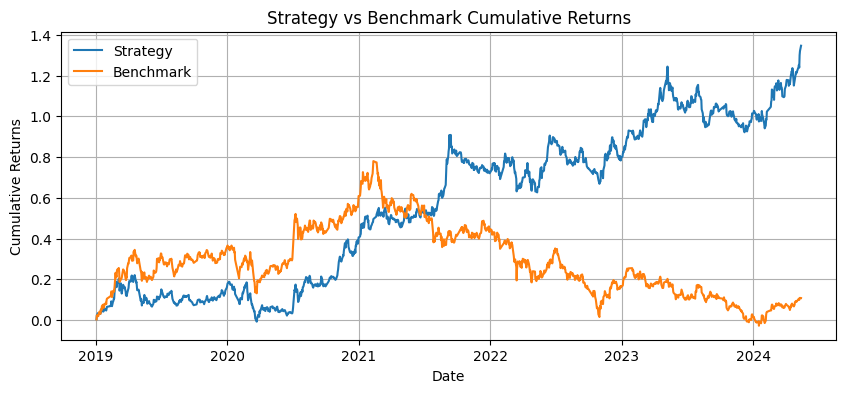

In [11]:
print("开始打印回测相关指标...")
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.get_value()}")

def plot_strategy_benchmark_returns(strategy_returns, benchmark_returns):
    import matplotlib.pyplot as plt
    # 检查index是否一致以保证对齐
    if not strategy_returns.index.equals(benchmark_returns.index):
        raise ValueError("Indexes of strategy_returns and benchmark_returns must match")
    # 计算累积收益率
    strategy_cumulative_returns = (1 + strategy_returns).cumprod() - 1
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1
    # 绘制累积收益率曲线
    plt.figure(figsize=(10,4))
    plt.plot(strategy_cumulative_returns, label='Strategy')
    plt.plot(benchmark_cumulative_returns, label='Benchmark')
    # 添加标题和标签
    plt.title('Strategy vs Benchmark Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    # 显示图例
    plt.legend()
    # 显示网格
    plt.grid(True)
    # 显示绘制的图形
    plt.show()

custom_analysis = results[0].analyzers.custom_analyzer.get_analysis()
format_analysis_result = {"基准": {}, "策略": {}, "其他": {}}
for key, value in custom_analysis.items():
    if key.startswith("基准"):
        format_analysis_result["基准"][key] = round(value, 4)
    elif key.startswith("策略"):
        format_analysis_result["策略"][key] = round(value, 4)
    else:
        format_analysis_result["其他"][key] = round(value, 4)
pprint.pprint(format_analysis_result)

strategy_returns = pd.Series(results[0].analyzers.custom_analyzer.get_strategy_returns(), index=benchmark_data.index[1:])
benchmark_returns = pd.Series(results[0].analyzers.custom_analyzer.get_benchmark_returns(), index=benchmark_data.index[1:])
plot_strategy_benchmark_returns(strategy_returns, benchmark_returns)

In [12]:
annual_strategy_returns = strategy_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_benchmark_returns = benchmark_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns = pd.concat([annual_strategy_returns, annual_benchmark_returns], axis=1)
annual_returns.columns = ['Strategy', 'Benchmark']
annual_returns['Gap'] = annual_returns['Strategy'] - annual_returns['Benchmark']
annual_returns

,Strategy,Benchmark,Gap
2019-12-31,0.159595,0.353735,-0.194141
2020-12-31,0.212034,0.188501,0.023533
2021-12-31,0.226380,-0.100619,0.326999
2022-12-31,0.041399,-0.195177,0.236576
2023-12-31,0.122341,-0.117285,0.239626
2024-12-31,0.165024,0.077503,0.087521


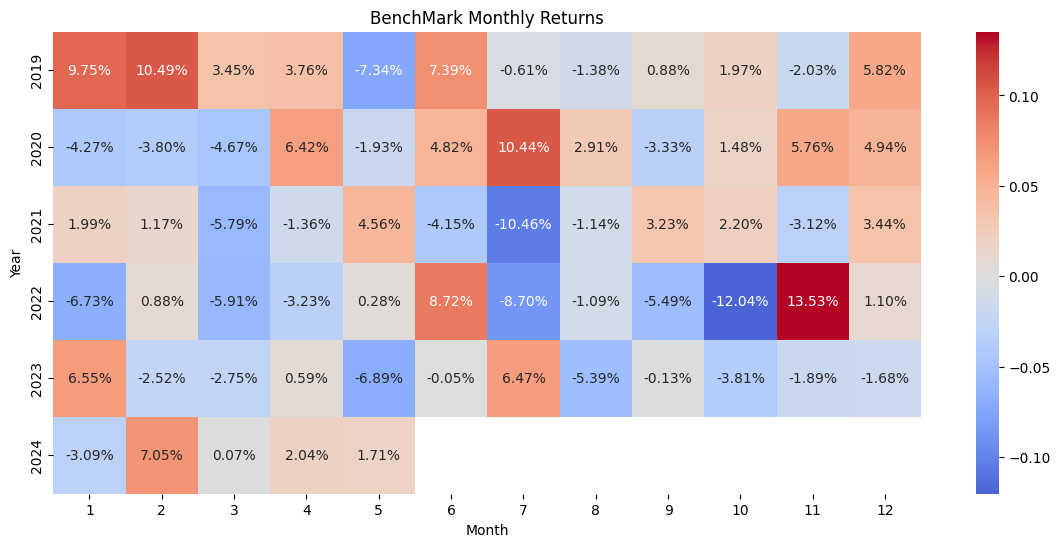

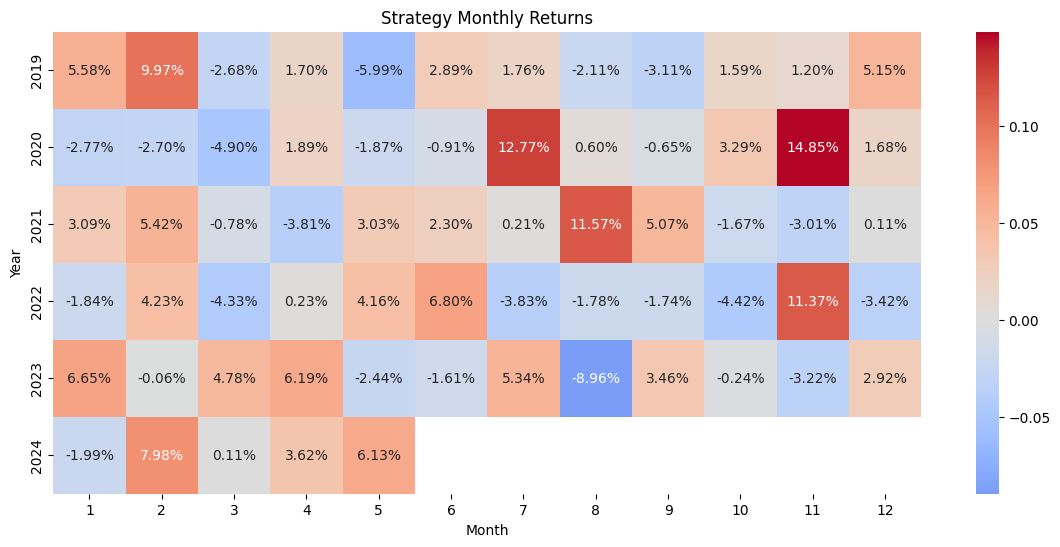

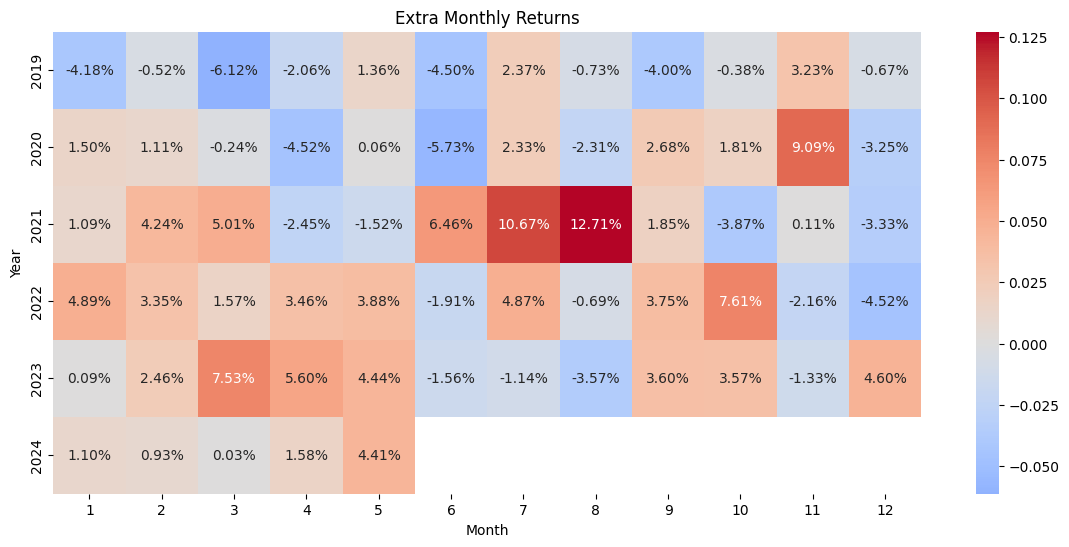

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_head_map(monthly_returns, name=''):
    monthly_returns_df = monthly_returns.to_frame(name='monthly_returns')
    # 创建新的列来代表年份和月份
    monthly_returns_df['Year'] = monthly_returns_df.index.year
    monthly_returns_df['Month'] = monthly_returns_df.index.month

    # 使用pivot方法来创建适合热力图的DataFrame
    pivot_table = monthly_returns_df.pivot(index='Year', columns='Month', values='monthly_returns')

    # 使用Seaborn绘制热力图
    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".2%",cmap='coolwarm', center=0)
    plt.title(name)
    plt.ylabel('Year')
    plt.xlabel('Month')
    plt.show()

# 假设 monthly_returns 是一个包含月度收益率的Series，并且它的索引是DateTimeIndex
# 如果它不是DataFrame，我们先将其转换成DataFrame
strategy_monthly_returns = strategy_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
benchmark_monthly_returns = benchmark_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
extra_monthly_returns = strategy_monthly_returns - benchmark_monthly_returns

plot_head_map(benchmark_monthly_returns, 'BenchMark Monthly Returns')
plot_head_map(strategy_monthly_returns, 'Strategy Monthly Returns')
plot_head_map(extra_monthly_returns, 'Extra Monthly Returns')

In [14]:
# !nvidia-smi

In [15]:
# import pandas as pd
# import numpy as np
# def get_stock_for_buy(group):
#     top_n = group.nlargest(3, "label_pred")
#     return top_n.to_dict("records")

# def get_stock_for_sell(group):
#     top_n = group.nsmallest(3, "label_pred")
#     return top_n.to_dict("records")

# model_prediction = pd.read_pickle('./backtest_data/test/000016_20190101_回归任务.pkl')
# stock_for_buy = model_prediction.groupby("datetime").apply(get_stock_for_buy).to_dict()
# stock_for_sell = model_prediction.groupby("datetime").apply(get_stock_for_sell).to_dict()